In [1]:
import os
#os.environ['R_HOME'] = '/home/h/hollenberg/miniconda3/envs/milopy-envv/lib/R' #path to your R installation
#os.environ['R_USER'] = '//home/h/hollenberg/miniconda3/envs/milopy-envv/lib/python3.11/site-packages/rpy2'
#home/h/hollenberg/miniconda3/envs/milopy-envv/bin/python
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import milopy
import milopy.core as milo
import milopy.plot as milopl
import milopy.utils

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [2]:
# path of partly preprocessed HLCA file used in this notebook:
adata_path = "/home/h/hollenberg/MaPra/datasets_seperate/galapagos_bleo.h5ad"

sample_identifier = "SAMP_ID" 
cell_type_identifier = "manual_celltype_annotation_fine_leiden03" 
covariate_obs = "SAMP_condition"


In [5]:
adata = sc.read(adata_path)

In [6]:
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)

In [7]:
milo.make_nhoods(adata, prop=0.1)
adata.obsm["nhoods"]
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
1_Sal_veh_d21_AACAAAGTCGTGCTCT-1,1,17.712694
1_Sal_veh_d21_AAGACAAGTCAGACTT-1,1,45.421268
1_Sal_veh_d21_AATCGACTCCTCGCAT-1,1,16.474922
1_Sal_veh_d21_ACCATTTGTGAGATAT-1,1,19.164955
1_Sal_veh_d21_ACCTACCCATGTTCGA-1,1,9.236434
...,...,...
9_Sal_veh_d21_TTGTTGTCATATCTGG-1,1,2.714502
9_Sal_veh_d21_TTTACGTTCCCGAGGT-1,1,3.132863
9_Sal_veh_d21_TTTACTGTCTACTTCA-1,1,4.333845
9_Sal_veh_d21_TTTACTGTCTGGGCCA-1,1,23.459946


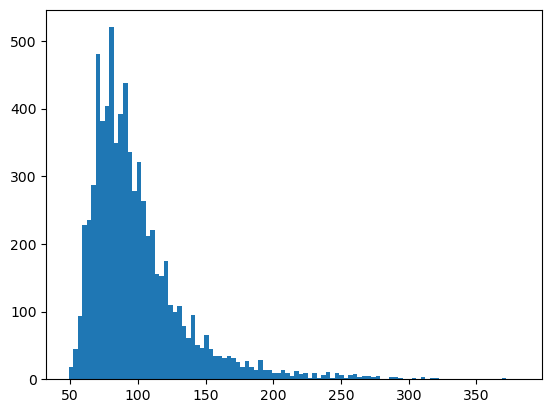

In [8]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

In [9]:
milo.count_nhoods(adata, sample_col=sample_identifier)
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 7253 × 43
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

In [10]:
adata.obs["condition_continuous"] = adata.obs[covariate_obs].astype('category').cat.codes
milo.DA_nhoods(adata, design="~condition_continuous")

In [11]:
adata.uns["nhood_adata"].obs

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,1_Sal_veh_d21_AACAAAGTCGTGCTCT-1,17.712694,-0.703777,7.863479,1.589829,0.209974,0.329513,0.339051
1,1_Sal_veh_d21_AAGACAAGTCAGACTT-1,45.421268,1.169550,7.985710,5.706705,0.017342,0.044430,0.050658
2,1_Sal_veh_d21_AATCGACTCCTCGCAT-1,16.474922,1.634828,8.028446,8.779089,0.003630,0.011875,0.014681
3,1_Sal_veh_d21_ACCATTTGTGAGATAT-1,19.164955,0.909553,8.067178,1.692063,0.199872,0.317688,0.327491
4,1_Sal_veh_d21_ACCTACCCATGTTCGA-1,9.236434,0.420679,8.069058,0.767475,0.381501,0.513554,0.520557
...,...,...,...,...,...,...,...,...
7248,9_Sal_veh_d21_TTGTTGTCATATCTGG-1,2.714502,1.657199,8.240141,12.416348,0.000472,0.002063,0.002848
7249,9_Sal_veh_d21_TTTACGTTCCCGAGGT-1,3.132863,2.246133,8.124167,18.997969,0.000017,0.000108,0.000175
7250,9_Sal_veh_d21_TTTACTGTCTACTTCA-1,4.333845,-0.109311,7.936166,0.050251,0.822736,0.888984,0.891561
7251,9_Sal_veh_d21_TTTACTGTCTGGGCCA-1,23.459946,-0.385995,7.887757,0.626150,0.429219,0.558008,0.565963


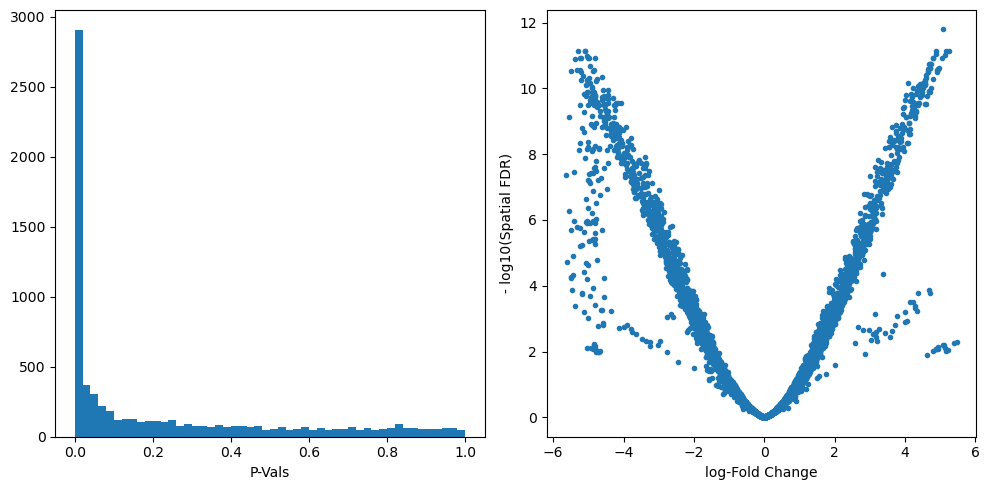

In [12]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [13]:
milopy.utils.build_nhood_graph(adata)

In [14]:
nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata

AnnData object with n_obs × n_vars = 7253 × 43
    obs: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'SpatialFDR', 'Nhood_size'
    var: 'condition_continuous', 'SAMP_ID'
    uns: 'sample_col', 'nhood'
    obsm: 'X_milo_graph'
    obsp: 'nhood_connectivities'

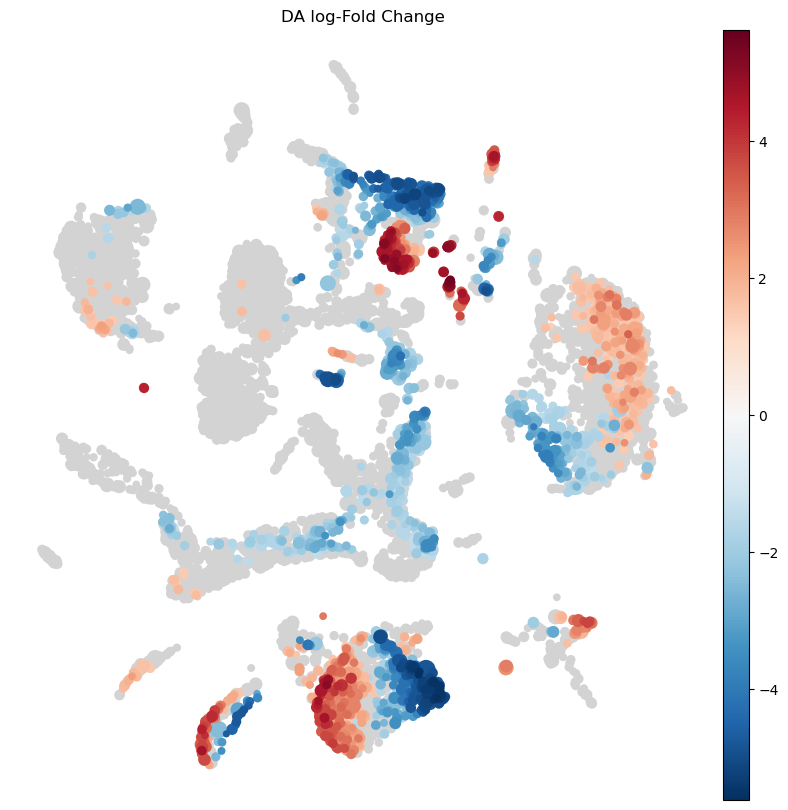

In [15]:
#import milopy.utils 
plt.rcParams["figure.figsize"] = [10,10]
milopl.plot_nhood_graph(adata,
    alpha=0.01, ## SpatialFDR level (1%)
    min_size=2 ## Size of smallest dot 
                       )

## Visualize result by celltype

In [20]:
milopy.utils.annotate_nhoods(adata, anno_col=cell_type_identifier)

ValueError: Must pass 2-d input. shape=()

In [ ]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [ ]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

In [ ]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()